In [2]:
%store -r
%store

Stored variables and their in-db values:
dw_output_path_prm             -> 's3://ml-predictivemaintainaince-28-01-2022/export


In [3]:
!pip install -qU 'sagemaker-experiments==0.1.24' 'sagemaker>=2.16.1' 'boto3' 'awswrangler'

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.5 which is incompatible.
awscli 1.22.23 requires botocore==1.23.23, but you have botocore 1.23.46 which is incompatible.
awscli 1.22.23 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.22.23 requires rsa<4.8,>=3.1.2, but you have rsa 4.8 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but

In [3]:
import os
import json
import sys
import collections
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
#import awswrangler as wr




In [15]:
smclient = boto3.Session().client("sagemaker")
region = boto3.Session().region_name

role = sagemaker.get_execution_role()

sess = sagemaker.Session()
bucket = "ml-predictivemaintainaince-28-01-2022"#sess.default_bucket()
prefix_prm = "predmaint"

In [6]:
fleet = pd.read_csv("data/fleet_data.csv")

In [6]:
fleet.head()

,target,vehicle_id,datetime,make,model,year,vehicle_class,engine_type,make_code_Make A,make_code_Make B,...,engine_type_code_Engine F,engine_type_code_Engine H,engine_type_code_Engine D,engine_type_code_Engine A,engine_type_code_Engine G,voltage,current,resistance,cycle,engine_age
0,0,0,2020-01-01 00:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,14.103421,0.177269,133.059603,1.0,2
1,0,0,2020-01-01 02:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,14.050759,0.172590,129.292756,2.0,2
2,0,0,2020-01-01 04:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,13.986414,0.167741,129.006131,3.0,2
3,0,0,2020-01-01 06:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,13.995525,0.175704,121.892551,4.0,2
4,0,0,2020-01-01 08:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,14.015038,0.173812,107.200838,5.0,2


Text(0, 0.5, 'resistance')

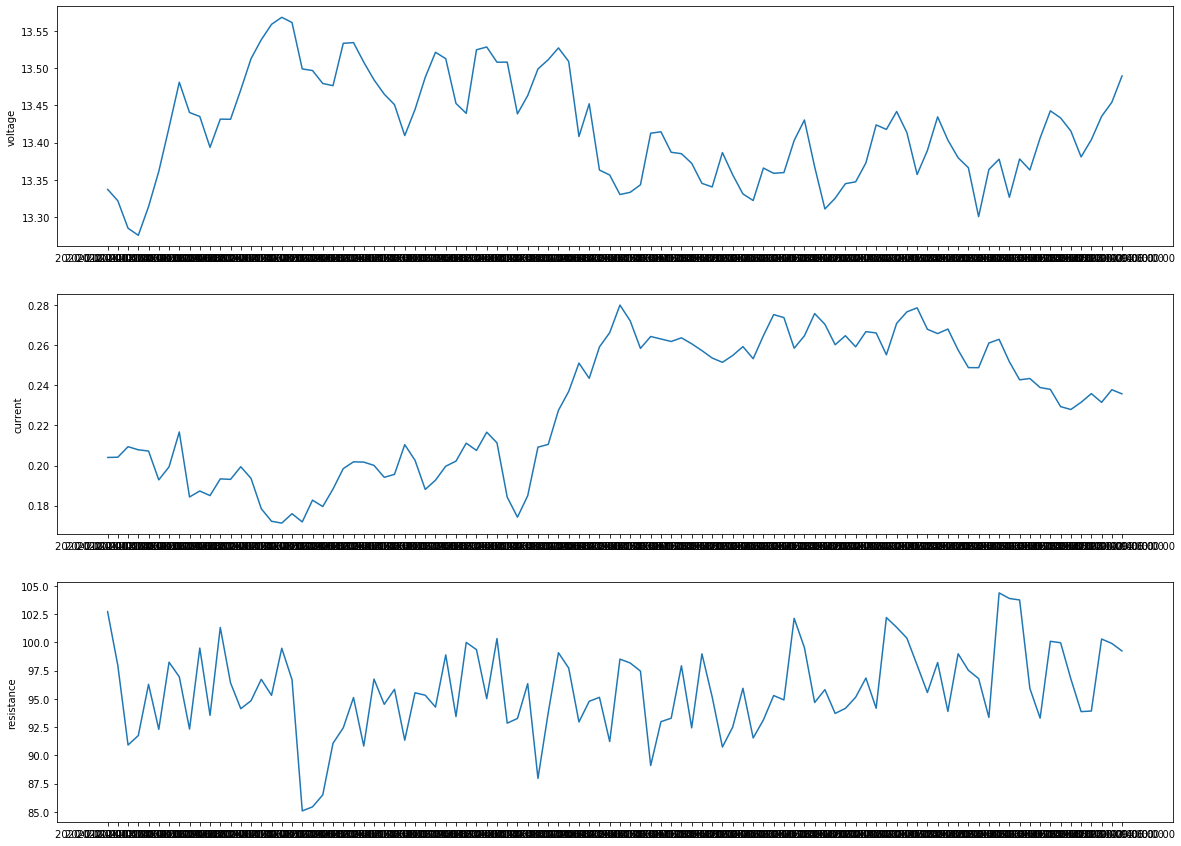

In [7]:
%matplotlib inline

fig,axs = plt.subplots(3,1,figsize=(20,15))
plot_fleet = fleet.loc[fleet["vehicle_id"] == 1]
sns.set_style("darkgrid")
axs[0].plot(plot_fleet["datetime"],plot_fleet["voltage"])
axs[1].plot(plot_fleet["datetime"],plot_fleet["current"])
axs[2].plot(plot_fleet["datetime"],plot_fleet["resistance"])

axs[0].set_ylabel("voltage")
axs[1].set_ylabel("current")
axs[2].set_ylabel("resistance")

Text(0, 0.5, 'resistance')

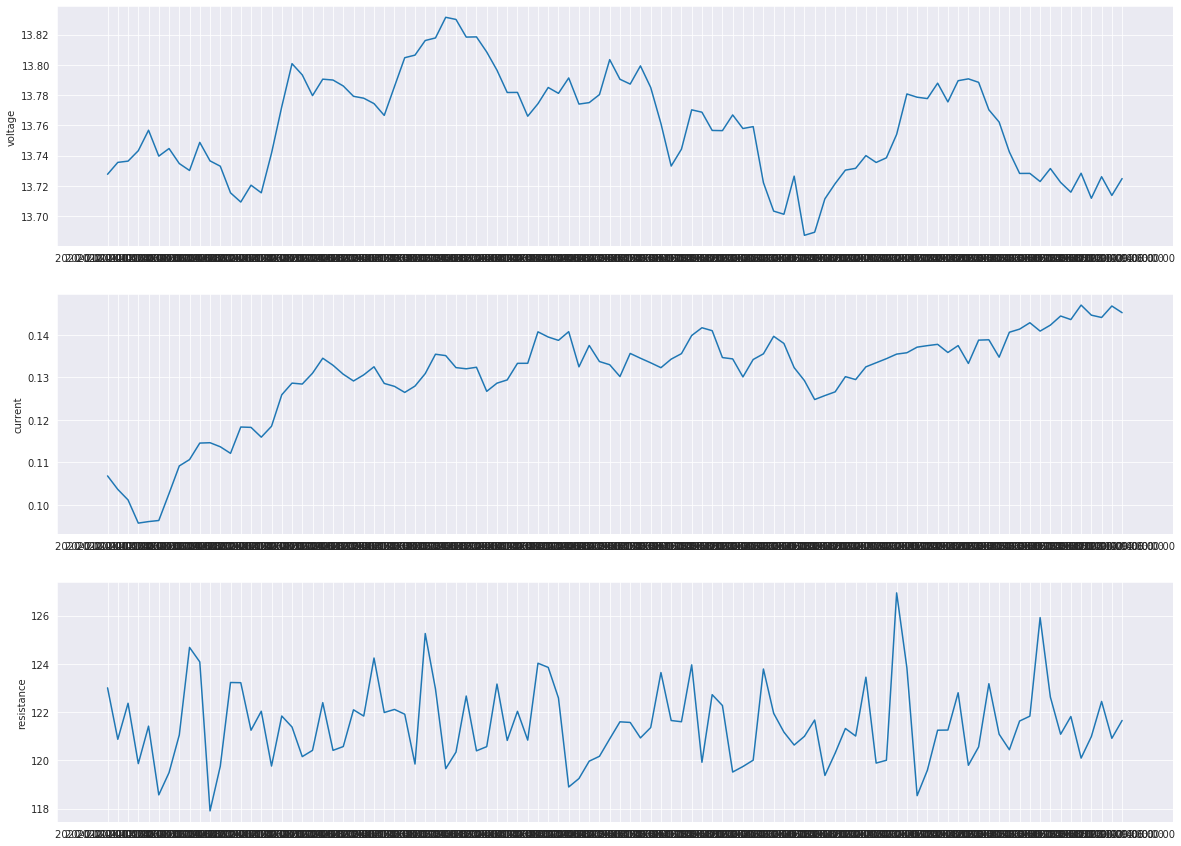

In [8]:
fig, axs = plt.subplots(3,1,figsize=(20,15))
plot_fleet = fleet.loc[fleet["vehicle_id"] == 2]

sns.set_style("darkgrid")
axs[0].plot(plot_fleet["datetime"],plot_fleet["voltage"])
axs[1].plot(plot_fleet["datetime"],plot_fleet["current"])
axs[2].plot(plot_fleet["datetime"],plot_fleet["resistance"])

axs[0].set_ylabel("voltage")
axs[1].set_ylabel("current")
axs[2].set_ylabel("resistance")

In [7]:
#failures vs non-failures
print(fleet["target"].value_counts())
print(
        "\n Percent of failures in the dataset : " + str(fleet["target"].value_counts()[1]/ len(fleet["target"]))
)

print("Number of vehicles with 1+ failures : "
        + str(fleet[fleet["target"] == 1]["vehicle_id"].drop_duplicates().count()))

#view the percent distribution of target column
print(fleet["target"].value_counts()/np.float(len(fleet)))

0    7238
1    1762
Name: target, dtype: int64

 Percent of failures in the dataset : 0.19577777777777777
Number of vehicles with 1+ failures : 49
0    0.804222
1    0.195778
Name: target, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


In [8]:
p = fleet.groupby(["vehicle_id"])["target"].sum().rename("Percentage of Failures")
print(p)
fail_percent = pd.DataFrame(p/100)
print(fail_percent.sort_values("Percentage of Failures",ascending=False).head(20))


vehicle_id
0      0
1      0
2      5
3     88
4      7
      ..
85    42
86    24
87     0
88     0
89     0
Name: Percentage of Failures, Length: 90, dtype: int64
            Percentage of Failures
vehicle_id                        
84                            1.00
65                            1.00
17                            1.00
71                            1.00
28                            0.99
15                            0.92
3                             0.88
63                            0.76
31                            0.74
40                            0.73
75                            0.67
6                             0.66
73                            0.61
42                            0.58
64                            0.49
85                            0.42
16                            0.40
22                            0.38
39                            0.36
26                            0.35


In [7]:
print(fleet.isnull().sum())

target                              0
vehicle_id                          0
datetime                            0
make                                0
model                               0
year                                0
vehicle_class                       0
engine_type                         0
make_code_Make A                    0
make_code_Make B                    0
make_code_Make E                    0
make_code_Make C                    0
make_code_Make D                    0
model_code_Model E1                 0
model_code_Model A4                 0
model_code_Model B1                 0
model_code_Model B2                 0
model_code_Model A2                 0
model_code_Model A3                 0
model_code_Model B3                 0
model_code_Model C2                 0
model_code_Model A1                 0
model_code_Model A5                 0
model_code_Model A6                 0
model_code_Model C1                 0
model_code_Model D1                 0
model_code_M

In [9]:
fleet[fleet.loc[:,"voltage":"resistance"].values == 0]

,target,vehicle_id,datetime,make,model,year,vehicle_class,engine_type,make_code_Make A,make_code_Make B,...,engine_type_code_Engine F,engine_type_code_Engine H,engine_type_code_Engine D,engine_type_code_Engine A,engine_type_code_Engine G,voltage,current,resistance,cycle,engine_age


Feature engineering---->

In [10]:
fleet.datetime = pd.to_datetime(fleet.datetime)

In [11]:
for i in range(1,2):
    fleet["voltage_lag_" +str(i)] = (
        fleet.groupby("vehicle_id")["voltage"].shift(i).fillna(method="bfill",limit=7)
    )
    fleet["current_lag_" + str(i)] = (
        fleet.groupby("vehicle_id")["current"].shift(i).fillna(method="bfill",limit=7)    
        
    )
    fleet["resistance_lag_" + str(i)] = (
        fleet.groupby("vehicle_id")["resistance"].shift(i).fillna(method="bfill",limit=7)
    )

In [12]:
#create rolling stats for voltage, current and resistance
stats = pd.DataFrame()
grouped = fleet.groupby("vehicle_id")

mean=[
    (col+"_"+"rolling_mean_"+str(win),grouped[col].rolling(window=win).mean())
    for win in [4]
    for col in ["voltage","current","resistance"]
]

std = [
    (col + "_"+"rolling_std_"+str(win),grouped[col].rolling(window=win).std())
    for win in [4]
    for col in ["voltage","current","resistance"]
]

df_mean = pd.DataFrame.from_dict(collections.OrderedDict(mean))
df_std = pd.DataFrame.from_dict(collections.OrderedDict(std))
stats = (
    pd.concat([df_mean,df_std],axis=1)
    .reset_index()
    .set_index("level_1")
    .fillna(method="bfill",limit=7)
)
stats.head(5)

,vehicle_id,voltage_rolling_mean_4,current_rolling_mean_4,resistance_rolling_mean_4,voltage_rolling_std_4,current_rolling_std_4,resistance_rolling_std_4
level_1,,,,,,,
0,0,14.034030,0.173326,128.312760,0.054298,0.004201,4.661643
1,0,14.034030,0.173326,128.312760,0.054298,0.004201,4.661643
2,0,14.034030,0.173326,128.312760,0.054298,0.004201,4.661643
3,0,14.034030,0.173326,128.312760,0.054298,0.004201,4.661643
4,0,14.011934,0.172462,121.848069,0.028505,0.003398,10.347376


In [13]:
fleet_lagged = pd.concat([fleet,stats.drop(columns=["vehicle_id"])],axis=1)
fleet_lagged.head(2)

,target,vehicle_id,datetime,make,model,year,vehicle_class,engine_type,make_code_Make A,make_code_Make B,...,engine_age,voltage_lag_1,current_lag_1,resistance_lag_1,voltage_rolling_mean_4,current_rolling_mean_4,resistance_rolling_mean_4,voltage_rolling_std_4,current_rolling_std_4,resistance_rolling_std_4
0,0,0,2020-01-01 00:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,2,14.103421,0.177269,133.059603,14.03403,0.173326,128.31276,0.054298,0.004201,4.661643
1,0,0,2020-01-01 02:00:00,Make A,Model A1,2018,Truck,Engine A,1.0,0.0,...,2,14.103421,0.177269,133.059603,14.03403,0.173326,128.31276,0.054298,0.004201,4.661643


In [18]:
# let's look at the descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution
round(fleet_lagged.describe(),2).T

,count,mean,std,min,25%,50%,75%,max
target,9000.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
vehicle_id,9000.0,44.50,25.98,0.00,22.00,44.50,67.00,89.00
year,9000.0,2016.07,3.06,2006.00,2015.00,2017.00,2018.00,2020.00
make_code_Make A,9000.0,0.40,0.49,0.00,0.00,0.00,1.00,1.00
make_code_Make B,9000.0,0.24,0.43,0.00,0.00,0.00,0.00,1.00
make_code_Make E,9000.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
make_code_Make C,9000.0,0.11,0.31,0.00,0.00,0.00,0.00,1.00
make_code_Make D,9000.0,0.04,0.21,0.00,0.00,0.00,0.00,1.00
model_code_Model E1,9000.0,0.18,0.38,0.00,0.00,0.00,0.00,1.00
model_code_Model A4,9000.0,0.13,0.34,0.00,0.00,0.00,0.00,1.00


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


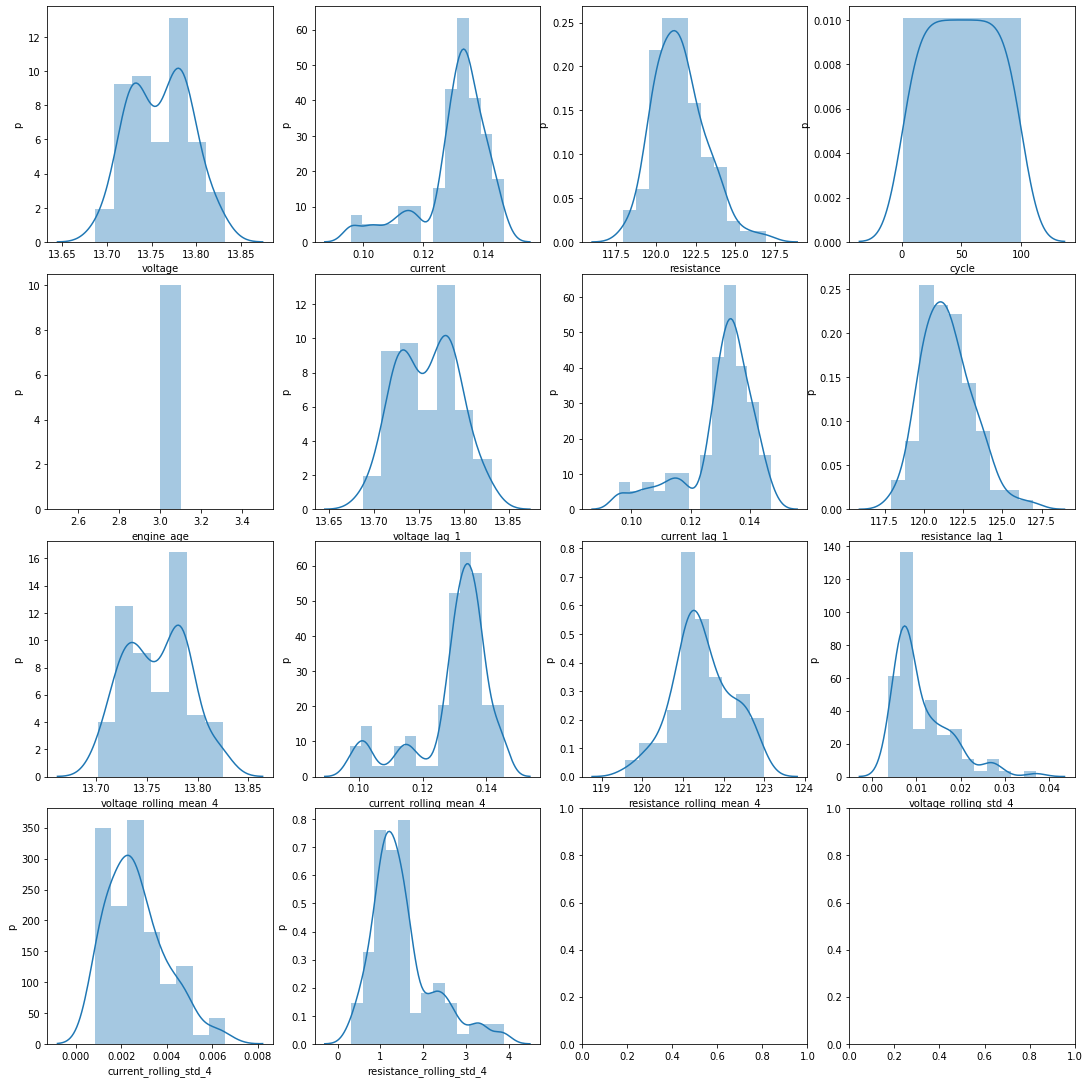

In [22]:
#Visualization of the data distribution
#plit a single engine histogram

def plot_engine_hists(sensor_data):
    cols = sensor_data.columns
    n_cols = min(len(cols),4)
    n_rows = int(np.ceil(len(cols) / n_cols))

    
    fig,axes = plt.subplots(n_rows,n_cols,figsize=(15,15))
    plt.tight_layout()
    
    axes = axes.flatten()
    for col,ax in zip(cols,axes):
        sns.distplot(sensor_data[[col]],ax=ax,label=col)
        ax.set_xlabel(col)
        ax.set_ylabel("p")

        
plot_engine_hists(fleet_lagged[fleet_lagged["vehicle_id"] ==2].loc[:,"voltage":])

In [24]:
features = fleet_lagged.drop(columns=["make","model","year","vehicle_class","engine_type"])
features.to_csv("data/features.csv",index=False)
features_created_prm=True
%store features_created_prm

Stored 'features_created_prm' (bool)


In [4]:
#Splitting the data for train test and Validation
features = pd.read_csv("data/features.csv")

Splitting data into train test and validation

In [5]:
#We will devote 80% to training and we will save 10% for test and 10%

train_size = int(len(features)*0.8)
val_size = int(len(features)*0.10)

ordered = features.sort_values("datetime")

#make train, test and validation splits

train,test,val =(
    ordered[0:train_size],
    ordered[train_size : train_size + val_size],
    ordered.tail(val_size),
)

train.sort_values(["vehicle_id","datetime"],inplace=True)

#Make sure there is no data leakage between train,test and validations
test = test.loc[test["datetime"] > train["datetime"].max()]
val = val.loc[val["datetime"] > test["datetime"].max()]

print("First train datetime " , train["datetime"].min())
print("Last train datetime" , train["datetime"].max())
print("First test datetime" , test["datetime"].min())
print("Last test datetime ", test["datetime"].max())
print("First validation datetime" , val["datetime"].min())
print("Last validation datetime" ,val["datetime"].max())

First train datetime  2020-01-01 00:00:00
Last train datetime 2020-01-07 14:00:00
First test datetime 2020-01-07 16:00:00
Last test datetime  2020-01-08 10:00:00
First validation datetime 2020-01-08 12:00:00
Last validation datetime 2020-01-09 06:00:00


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [9]:
train = train.drop(["datetime","vehicle_id"],axis=1)
test = test.sort_values(["vehicle_id","datetime"])
test = test.drop(["datetime","vehicle_id"],axis=1)
val=val.sort_values(["vehicle_id","datetime"])
val=val.drop(["datetime","vehicle_id"],axis=1)

In [6]:
print("Total Observations ", len(ordered))
print("Number of observations in the training data : " , len(train))
print("Number of observations in the test data ", len(test))
print("Number of observations in the validations data : ", len(val))

Total Observations  9000
Number of observations in the training data :  7200
Number of observations in the test data  900
Number of observations in the validations data :  900


Converting data to the appropriate format for Estimator

In [7]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler(feature_range=(0.0,1.0))


In [10]:
train = pd.DataFrame(scaler.fit_transform(train))


In [11]:
test = pd.DataFrame(scaler.transform(test))
val = pd.DataFrame(scaler.transform(val))

In [19]:
def upload_file_to_bucket(df,bucket,prefix,filepath):
    file_dir, file_name = os.path.split(filepath)
    df.to_csv(file_name,header=False,index=False)
    boto3.resource("s3").meta.client.upload_file(
        Filename=filepath,Bucket=bucket,Key=(prefix+"/"+file_name)
    )
    print(f"upload {prefix} data location: s3: //{bucket}/{prefix}/{file_name}")
    path_to_data = f"s3://{bucket}/{prefix}/{file_name}"
    return path_to_data

In [20]:
#convert and upload to s3

path_to_train_data_prm = upload_file_to_bucket(train,bucket,"train","train.csv")


upload train data location: s3: //ml-predictivemaintainaince-28-01-2022/train/train.csv


In [21]:
path_to_test_data_prm = upload_file_to_bucket(test,bucket,"test","test.csv")
path_test_data_x_data_prm = upload_file_to_bucket(test.loc[:,1:],bucket,"test","test_x.csv")
path_to_valid_data_prm = upload_file_to_bucket(val,bucket,"validation","validation.csv")


output_location=f"s3://{bucket}/output"
print("training artifact will be uploaded to {}".format(output_location))


upload test data location: s3: //ml-predictivemaintainaince-28-01-2022/test/test.csv
upload test data location: s3: //ml-predictivemaintainaince-28-01-2022/test/test_x.csv
upload validation data location: s3: //ml-predictivemaintainaince-28-01-2022/validation/validation.csv
training artifact will be uploaded to s3://ml-predictivemaintainaince-28-01-2022/output
Stored 'path_to_train_data_prm' (str)
Stored 'path_to_test_data_prm' (str)


UsageError: Unknown variable 'path_to_test_x_data_prm'


In [27]:
path_to_test_x_data_prm = path_test_data_x_data_prm
%store path_to_train_data_prm
%store path_to_test_data_prm
%store path_to_test_x_data_prm
%store path_to_valid_data_prm

Stored 'path_to_train_data_prm' (str)
Stored 'path_to_test_data_prm' (str)
Stored 'path_to_test_x_data_prm' (str)
Stored 'path_to_valid_data_prm' (str)


In [29]:
from sagemaker.inputs import TrainingInput

train_channel = TrainingInput(path_to_train_data_prm, content_type="text/csv")
test_channel = TrainingInput(path_to_test_data_prm, content_type="text/csv")
test_x_channel = TrainingInput(path_to_test_x_data_prm,content_type="text/csv")
valid_channel = TrainingInput(path_to_valid_data_prm,content_type="text/csv")



In [30]:
data_channel = {"train" : train_channel,"validation" : valid_channel}
%store data_channel

Stored 'data_channel' (dict)
